# Loading the dataset

In [ ]:
from urllib.request import urlretrieve
import os, ssl

# directory path to store data
output_relative_dir = './data'

# check if it exists as it makedir will raise an error if it does exist
if not os.path.exists(output_relative_dir):
    os.makedirs(output_relative_dir)

In [ ]:
YEAR = '2021'
MONTHS = range(11,13)
URL_TEMPLATE = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_"#year-month.parquet

In [ ]:
tlc_output_dir = output_relative_dir

for month in MONTHS:
    # 0-fill i.e 1 -> 01, 2 -> 02, etc
    month = str(month).zfill(2) 
    print(f"Begin month {month}")
    
    # generate url
    url = f'{URL_TEMPLATE}{YEAR}-{month}.parquet'
    # generate output location and filename
    output_dir = f"{tlc_output_dir}/{YEAR}-{month}.parquet"

    if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
        ssl._create_default_https_context = ssl._create_unverified_context
    # download
    urlretrieve(url, output_dir) 
    
    print(f"Completed month {month}")

In [1]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("ADS")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/08/18 22:05:39 WARN Utils: Your hostname, Harshitas-MacBook-Air-8.local resolves to a loopback address: 127.0.0.1; using 192.168.0.227 instead (on interface en0)
22/08/18 22:05:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/18 22:05:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/18 22:05:41 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
sdf = spark.read.parquet('./data')

In [17]:
from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import folium

In [20]:
small_df = sdf.sample(0.05, seed=None)
small_df = small_df.toPandas()

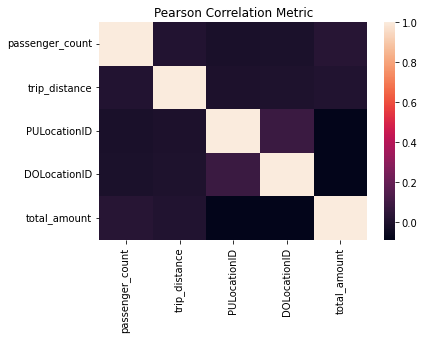

In [6]:
# sdf.filter(F.col('passenger_count') >= 2).count()
CORR_COLS = ["passenger_count", "trip_distance", "PULocationID", "DOLocationID", "total_amount"]
sns.heatmap(small_df[CORR_COLS].corr())

plt.title('Pearson Correlation Metric')
plt.show()

In [14]:
zones = pd.read_csv("./data/taxi+_zone_lookup.csv")
sf = gpd.read_file("./data/taxi_zones.shp")
# attribute tute code
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

In [16]:
gdf = gpd.GeoDataFrame(pd.merge(zones, sf, on='LocationID', how='inner'))
# create a JSON 
geoJSON = gdf[['LocationID', 'geometry']] \
    .drop_duplicates('LocationID').to_json()

In [21]:
small_df = small_df \
    .merge(gdf[['LocationID', 'geometry']], left_on='PULocationID', right_on='LocationID') \
    .drop('LocationID', axis=1)

<AxesSubplot:>

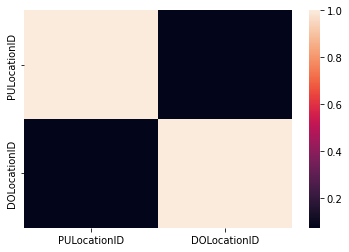

In [25]:
CORR = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PULocationID', 'DOLocationID', 'geometry']
sns.heatmap(small_df[CORR].corr())

In [26]:
gdf.loc[gdf['Zone'].str.contains('Airport')]

,LocationID,Borough,Zone,service_zone,OBJECTID,Shape_Leng,Shape_Area,zone,borough,geometry
0,1,EWR,Newark Airport,EWR,1,0.116357,0.000782,Newark Airport,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
131,132,Queens,JFK Airport,Airports,132,0.245479,0.002038,JFK Airport,Queens,"MULTIPOLYGON (((-73.82503 40.66358, -73.82486 ..."
137,138,Queens,LaGuardia Airport,Airports,138,0.107467,0.000537,LaGuardia Airport,Queens,"MULTIPOLYGON (((-73.87125 40.78604, -73.86978 ..."
